<a target="_blank" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/070_correlation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

(associations-notebook)=
# Le relazioni tra variabili

In questo capitolo esamineremo due indicatori statistici utilizzati per misurare la relazione lineare tra due variabili: la covarianza e la correlazione. Questi due strumenti sono fondamentali per comprendere il grado e la direzione dell'associazione tra le variabili, consentendoci di quantificare quanto variano insieme e in che modo. 

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import arviz as az
import graphviz
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

## Definizione delle relazioni tra variabili

Nel contesto delle indagini statistiche, spesso non ci limitiamo a esaminare la distribuzione di una singola variabile. Invece, il nostro interesse si concentra sulla relazione che emerge nei dati tra due o più variabili. Ma cosa significa esattamente quando diciamo che due variabili hanno una relazione?

Per comprendere ciò, prendiamo ad esempio l'altezza e l'età tra un gruppo di bambini. In generale, è possibile notare che all'aumentare dell'età di un bambino, aumenta anche la sua altezza. Pertanto, conoscere l'età di un bambino, ad esempio tredici anni, e l'età di un altro, sei anni, ci fornisce un'indicazione su quale dei due bambini sia più alto.

Nel linguaggio statistico, definiamo questa relazione tra altezza e età come positiva, il che significa che all'aumentare dei valori di una delle variabili (in questo caso, l'età), ci aspettiamo di vedere valori più elevati anche nell'altra variabile (l'altezza). Tuttavia, esistono anche relazioni negative, in cui l'aumento di una variabile è associato a un diminuzione dell'altra (ad esempio, più età è correlata a meno pianto).

Non si tratta solo di relazioni positive o negative; ci sono anche situazioni in cui le variabili non hanno alcuna relazione tra loro, definendo così una relazione nulla. Inoltre, le relazioni possono variare nel tempo, passando da positive a negative o da fortemente positive a appena positiva. In alcuni casi, una delle variabili può essere categorica, rendendo difficile parlare di "maggioranza" o "minoranza" ma piuttosto di "differente" (ad esempio, i bambini più grandi potrebbero semplicemente avere diverse preferenze rispetto ai bambini più piccoli, senza necessariamente essere "migliori" o "peggiori").

## Grafico a dispersione 

Il metodo più diretto per visualizzare la relazione tra due variabili continue è tramite un grafico a dispersione, comunemente noto come "scatterplot". Questo tipo di diagramma rappresenta le coppie di dati ottenute da due variabili, posizionandole sull'asse delle ascisse (orizzontale) e delle ordinate (verticale).

Per rendere l'idea più chiara, consideriamo i dati di uno studio condotto da {cite:t}`sec-zetsche-scatter`, in cui i ricercatori hanno utilizzato due scale psicometriche, il Beck Depression Inventory II (BDI-II) e la Center for Epidemiologic Studies Depression Scale (CES-D), per misurare il livello di depressione nei partecipanti. Il BDI-II è uno strumento di autovalutazione che valuta la presenza e l'intensità dei sintomi depressivi in pazienti adulti e adolescenti con diagnosi psichiatrica, mentre la CES-D è una scala di autovalutazione progettata per misurare i sintomi depressivi sperimentati nella settimana precedente nella popolazione generale, in particolare negli adolescenti e nei giovani adulti. Poiché entrambe le scale misurano lo stesso costrutto, ovvero la depressione, ci aspettiamo una relazione tra i punteggi ottenuti dal BDI-II e dalla CES-D. Un diagramma a dispersione ci consente di esaminare questa relazione in modo visuale e intuitivo.

Posizionando i valori del BDI-II sull'asse delle ascisse e quelli del CES-D sull'asse delle ordinate, ogni punto sul grafico rappresenta un individuo, di cui conosciamo il livello di depressione misurato dalle due scale. È evidente che i valori delle scale BDI-II e CES-D non possono coincidere per due motivi principali: (1) la presenza di errori di misurazione e (2) l'utilizzo di unità di misura arbitrarie per le due variabili. L'errore di misurazione è una componente inevitabile che influisce in parte su qualsiasi misurazione, ed è particolarmente rilevante in psicologia, dove la precisione degli strumenti di misurazione è generalmente inferiore rispetto ad altre discipline, come la fisica. Il secondo motivo per cui i valori delle scale BDI-II e CES-D non possono essere identici è che l'unità di misura della depressione è una questione arbitraria e non standardizzata. Tuttavia, nonostante le differenze dovute agli errori di misurazione e all'uso di unità di misura diverse, ci aspettiamo che, se le due scale misurano lo stesso costrutto (la depressione), i valori prodotti dalle due scale dovrebbero essere associati linearmente tra di loro. Per comprendere meglio il concetto di "associazione lineare", è possibile esaminare i dati attraverso l'utilizzo di un diagramma a dispersione.

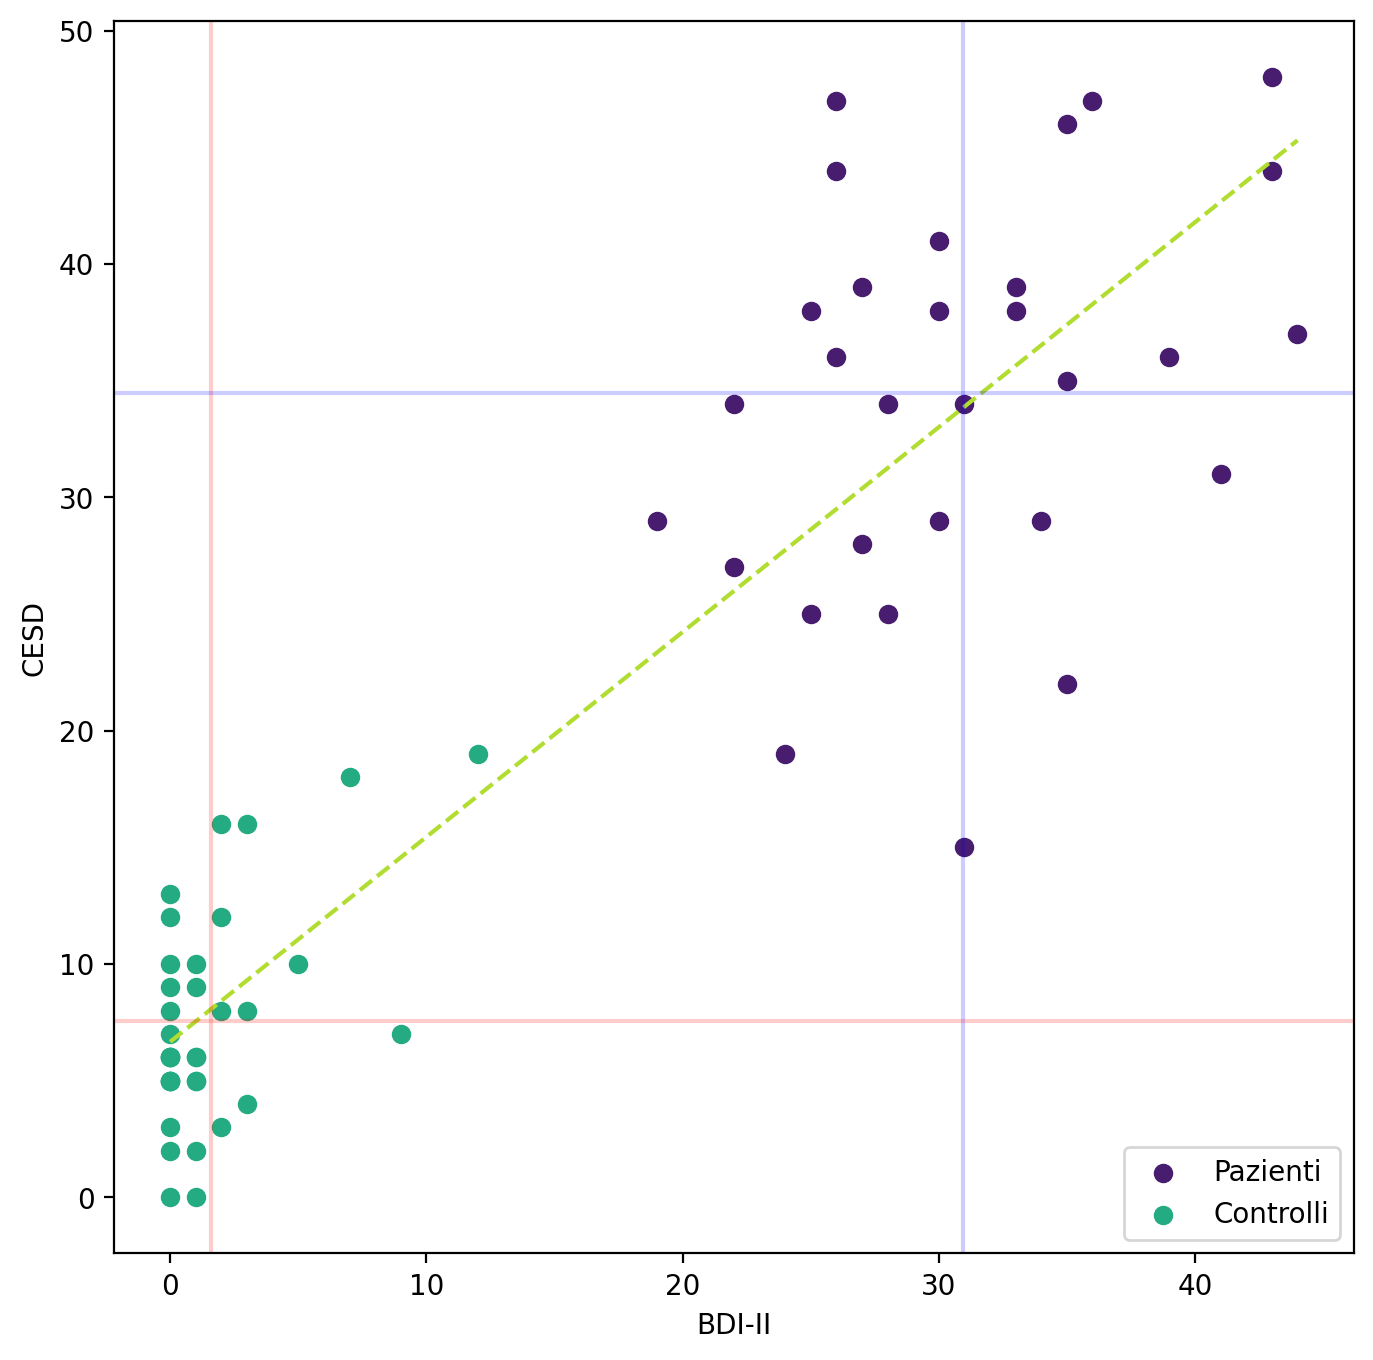

In [15]:
# Leggi i dati dal file CSV
df = pd.read_csv("../data/data.mood.csv", index_col=0)

# Seleziona le colonne di interesse
df = df[["esm_id", "group", "bdi", "cesd_sum"]]

# Rimuovi le righe duplicate
df = df.drop_duplicates(keep="first")

# Rimuovi le righe con valori mancanti nella colonna "bdi"
df = df.dropna(subset=["bdi"])

# Crea uno scatterplot con colori diversi per i due gruppi
plt.scatter(df[df["group"] == "mdd"]["bdi"], df[df["group"] == "mdd"]["cesd_sum"], label="Pazienti", c="C0")
plt.scatter(df[df["group"] == "ctl"]["bdi"], df[df["group"] == "ctl"]["cesd_sum"], label="Controlli", c="C2")

# Calcola i coefficienti della retta dei minimi quadrati
coeff_combined = np.polyfit(df["bdi"], df["cesd_sum"], 1)

# Calcola la retta dei minimi quadrati
line_combined = np.poly1d(coeff_combined)

# Disegna la retta dei minimi quadrati
x_values = np.linspace(df["bdi"].min(), df["bdi"].max(), 100)
plt.plot(x_values, line_combined(x_values), linestyle='--', color='C3')

# Etichette degli assi
plt.xlabel("BDI-II")
plt.ylabel("CESD")

# Linee verticali ed orizzontali per le medie
plt.axvline(np.mean(df[df["group"] == "mdd"]["bdi"]), alpha=0.2, color="blue")
plt.axvline(np.mean(df[df["group"] == "ctl"]["bdi"]), alpha=0.2, color="red")
plt.axhline(np.mean(df[df["group"] == "mdd"]["cesd_sum"]), alpha=0.2, color="blue")
plt.axhline(np.mean(df[df["group"] == "ctl"]["cesd_sum"]), alpha=0.2, color="red")

# Legenda
plt.legend()

# Mostra il grafico
plt.show()

Osservando il grafico a dispersione, è evidente che i dati mostrano una tendenza a distribuirsi in modo approssimativamente lineare. In termini statistici, ciò suggerisce una relazione di associazione lineare tra i punteggi CES-D e BDI-II.

Tuttavia, è importante notare che la relazione lineare tra le due variabili è lontana dall'essere perfetta. In una relazione lineare perfetta, tutti i punti nel grafico sarebbero allineati in modo preciso lungo una retta. Nella realtà, la dispersione dei punti dal comportamento lineare ideale è evidente.

Di conseguenza, sorge la necessità di quantificare numericamente la forza e la direzione della relazione lineare tra le due variabili e di misurare quanto i punti si discostino da una relazione lineare ideale. Esistono vari indici statistici a disposizione per raggiungere questo obiettivo.

## Covarianza

Iniziamo a considerare il più importante di tali indici, chiamato *covarianza*. In realtà la definizione di questo indice non ci sorprenderà più di tanto in quanto, in una forma solo apparentemente diversa, l'abbiamo già incontrata in precedenza. Ci ricordiamo infatti che la varianza di una generica variabile $X$ è definita come la media degli scarti quadratici di ciascuna osservazione dalla media:

$$
S_{XX} = \frac{1}{n} \sum_{i=1}^n(X_i - \bar{X}) (X_i - \bar{X}). 
$$

La varianza viene talvolta descritta come la "covarianza di una variabile con sé stessa". Adesso facciamo un passo ulteriore. Invece di valutare la dispersione di una sola variabile, ci chiediamo come due variabili $X$ e $Y$ "variano insieme" (co-variano). È facile capire come una risposta a tale domanda possa essere fornita da una semplice trasformazione della formula precedente che diventa:

$$
S_{XY} = \frac{1}{n} \sum_{i=1}^n(X_i - \bar{X}) (Y_i - \bar{Y}).
$$ (eq-cov-def)

L'eq. {eq}`eq-cov-def` ci fornisce la definizione della covarianza.

### Interpretazione

Per capire il significato dell'eq. {eq}`eq-cov-def`, supponiamo di dividere il grafico riportato nella sezione {ref}`sec-zetsche-scatter` in quattro quadranti definiti da una retta verticale passante per la media dei valori BDI-II e da una retta orizzontale passante per la media dei valori CES-D. Numeriamo i quadranti partendo da quello in basso a sinistra e muovendoci in senso antiorario.

Se prevalgono punti nel I e III quadrante, allora la nuvola di punti avrà un andamento crescente (per cui a valori bassi di $X$ tendono ad associarsi valori bassi di $Y$ e a valori elevati di $X$ tendono ad associarsi valori elevati di $Y$) e la covarianza avrà segno positivo. Mentre se prevalgono punti nel II e IV quadrante la nuvola di punti avrà un andamento decrescente (per cui a valori bassi di $X$ tendono ad associarsi valori elevati di $Y$ e a valori elevati di $X$ tendono ad associarsi valori bassi di $Y$) e la covarianza avrà segno negativo. Dunque, il segno della covarianza ci informa sulla direzione della relazione lineare tra due variabili: l'associazione lineare si dice positiva se la covarianza è positiva, negativa se la covarianza è negativa.

**Esercizio.** Implemento la {eq}`eq-cov-def` in Python.

In [5]:
def cov_value(x, y):

    mean_x = sum(x) / float(len(x))
    mean_y = sum(y) / float(len(y))

    sub_x = [i - mean_x for i in x]
    sub_y = [i - mean_y for i in y]

    sum_value = sum([sub_y[i] * sub_x[i] for i in range(len(x))])
    denom = float(len(x))

    cov = sum_value / denom
    return cov

Per i dati mostrati nel diagramma, la covarianza tra BDI-II e CESD è 207.4

In [6]:
x = df["bdi"]
y = df["cesd_sum"]

cov_value(x, y)

207.42653810835637

Oppure, in maniera più semplice:

In [7]:
np.mean((x - np.mean(x)) * (y - np.mean(y)))

207.42653810835628

Lo stesso risultato si ottiene con la funzione `cov` di NumPy.

In [8]:
np.cov(x, y, ddof=0)

array([[236.23875115, 207.42653811],
       [207.42653811, 222.83379247]])

## Correlazione

La direzione della relazione tra le variabili è indicata dal segno della covarianza, ma il valore assoluto di questo indice non fornisce informazioni utili poiché dipende dall'unità di misura delle variabili. Ad esempio, considerando l'altezza e il peso delle persone, la covarianza sarà più grande se l'altezza è misurata in millimetri e il peso in grammi, rispetto al caso in cui l'altezza è in metri e il peso in chilogrammi. Pertanto, per descrivere la forza e la direzione della relazione lineare tra due variabili in modo adimensionale, si utilizza l'indice di correlazione.

La correlazione è ottenuta standardizzando la covarianza tramite la divisione delle deviazioni standard ($s_X$, $s_Y$) delle due variabili:

$$ 
r_{XY} = \frac{S_{XY}}{S_X S_Y}. 
$$ (eq-cor-def)

La quantità che si ottiene in questo modo viene chiamata *correlazione* di Bravais-Pearson (dal nome degli autori che, indipendentemente l'uno dall'altro, l'hanno introdotta).

### Proprietà

Il coefficiente di correlazione ha le seguenti proprietà:

-   ha lo stesso segno della covarianza, dato che si ottiene dividendo la covarianza per due numeri positivi;
-   è un numero puro, cioè non dipende dall'unità di misura delle variabili;
-   assume valori compresi tra -1 e +1.

### Interpretazione  

All'indice di correlazione possiamo assegnare la seguente interpretazione:

1.  $r_{XY} = -1$ $\rightarrow$ perfetta relazione negativa: tutti i punti si trovano esattamente su una retta con pendenza negativa (dal quadrante in alto a sinistra al quadrante in basso a destra);
2.  $r_{XY} = +1$ $\rightarrow$ perfetta relazione positiva: tutti i punti si trovano esattamente su una retta con pendenza positiva (dal quadrante in basso a sinistra al quadrante in alto a destra);
3.  $-1 < r_{XY} < +1$ $\rightarrow$ presenza di una relazione lineare di intensità diversa;
4.  $r_{XY} = 0$ $\rightarrow$ assenza di relazione lineare tra $X$ e $Y$.

**Esercizio.** Per i dati riportati nel diagramma della sezione {ref}`sec-zetsche-scatter`, la covarianza è 207.4. Il segno positivo della covarianza ci dice che tra le due variabili c'è un'associazione lineare positiva. Per capire quale sia l'intensità della relazione lineare calcoliamo la correlazione. Essendo le deviazioni standard del BDI-II e del CES-D rispettavamente uguali a 15.37 e 14.93, la correlazione diventa uguale a $\frac{207.426}{15.38 \cdot 14.93} = 0.904.$ Tale valore è prossimo a 1.0, il che vuol dire che i punti del diagramma a dispersione non si discostano troppo da una retta con una pendenza positiva.

Troviamo la correlazione con la funzione `corrcoef()`:

In [9]:
np.corrcoef(x, y)

array([[1.        , 0.90406202],
       [0.90406202, 1.        ]])

Replichiamo il risultato implementando l'eq. {eq}`eq-cor-def`: 

In [18]:
s_xy = np.mean((x - np.mean(x)) * (y - np.mean(y)))
s_x = x.std(ddof=0)
s_y = y.std(ddof=0)
r_xy = s_xy / (s_x * s_y)
print(r_xy)

0.9040620189474861


Un altro modo ancora per trovare la correlazione tra i punteggi BDI-II e CESD è quello di standardizzare le due variabili per poi applicare la formula della covarianza:

In [10]:
z_x = (x - np.mean(x)) / np.std(x, ddof=0)
z_y = (y - np.mean(y)) / np.std(y, ddof=0)
np.mean(z_x * z_y)

0.9040620189474862

## Correlazione di Spearman

Un'alternativa per valutare la relazione lineare tra due variabili è il coefficiente di correlazione di Spearman, che si basa esclusivamente sull'ordine dei dati e non sugli specifici valori. Questo indice di associazione è particolarmente adatto quando gli psicologi sono in grado di misurare solo le relazioni di ordine tra diverse modalità di risposta dei soggetti, ma non l'intensità della risposta stessa. Tali variabili psicologiche che presentano questa caratteristica sono definite come "ordinali".

```{admonition} Nota
È importante ricordare che, nel caso di una variabile ordinale, non è possibile utilizzare le statistiche descrittive convenzionali come la media e la varianza per sintetizzare le osservazioni. Tuttavia, è possibile riassumere le osservazioni attraverso una distribuzione di frequenze delle diverse modalità di risposta. Come abbiamo appena visto, la direzione e l'intensità dell'associazione tra due variabili ordinali possono essere descritte utilizzando il coefficiente di correlazione di Spearman.
```

Per fornire un esempio, consideriamo due variabili di scala ordinale e calcoliamo la correlazione di Spearman tra di esse.

In [ ]:
stats.spearmanr([1, 2, 3, 4, 5], [5, 6, 7, 8, 7])

## Correlazione nulla

Un aspetto finale da sottolineare riguardo alla correlazione è che essa descrive la direzione e l'intensità della *relazione lineare* tra due variabili. Tuttavia, la correlazione non cattura relazioni non lineari tra le variabili, anche se possono essere molto forti. È fondamentale comprendere che una correlazione pari a zero non implica l'assenza di una relazione tra le due variabili, ma indica solamente l'assenza di una relazione lineare tra di esse.

La figura seguente fornisce tredici esempi di correlazione nulla in presenza di una chiara relazione (non lineare) tra due variabili. In questi tredici insiemi di dati i coefficienti di correlazione di Pearson sono sempre uguali a 0. Ma questo non significa che non vi sia alcuna relazione tra le variabili.

In [ ]:
datasaurus_data = pd.read_csv("../data/datasaurus.csv")
datasaurus_data.groupby("dataset").agg(
    {"x": ["count", "mean", "std"], "y": ["count", "mean", "std"]}
)

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
datasets = datasaurus_data["dataset"].unique()

for i, dataset in enumerate(datasets):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    subset = datasaurus_data[datasaurus_data["dataset"] == dataset]
    ax.scatter(subset["x"], subset["y"], alpha=0.7)
    ax.set_title(dataset)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.tight_layout()
plt.show()

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w